In [1]:
%load_ext autoreload
import os
# os.environ["CUDA_VISIBLE_DEVICES"]='0,1,2,3'
import sys

import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import torchvision
import videotransforms
import mit_data
from mit_data import MITDataset as Dataset
from mit_data import make_label_binarizer
from pytorch_i3d import InceptionI3d
from torchvision import transforms
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
batch_size = 2

In [45]:
%autoreload
train_transforms = transforms.Compose([
    videotransforms.RandomCrop(224),
    videotransforms.RandomHorizontalFlip(),
])
test_transforms = transforms.Compose([videotransforms.CenterCrop(224)])

mlb = make_label_binarizer("data/MIT_data/train_index.csv")
num_classes = len(mlb.classes_)

val_dataset = Dataset(mlb, mode="val", transforms=test_transforms)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3,
    pin_memory=True)



train_dataset = Dataset(mlb, mode="train", transforms=test_transforms)

i3d = InceptionI3d(400, in_channels=3, spatial_squeeze=True)
i3d.replace_logits(num_classes)

In [55]:
checkpoint = torch.load("learning_history/train.pt034650.pt", map_location="cpu")
i3d.load_state_dict(checkpoint)
i3d.eval()

InceptionI3d(
  (avg_pool): AvgPool3d(kernel_size=[2, 7, 7], stride=(1, 1, 1), padding=0)
  (dropout): Dropout(p=0.5)
  (logits): Unit3D(
    (conv3d): Conv3d(1024, 195, kernel_size=[1, 1, 1], stride=(1, 1, 1))
  )
  (Conv3d_1a_7x7): Unit3D(
    (conv3d): Conv3d(3, 64, kernel_size=[7, 7, 7], stride=(2, 2, 2), bias=False)
    (bn): BatchNorm3d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  )
  (MaxPool3d_2a_3x3): MaxPool3dSamePadding(kernel_size=[1, 3, 3], stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (Conv3d_2b_1x1): Unit3D(
    (conv3d): Conv3d(64, 64, kernel_size=[1, 1, 1], stride=(1, 1, 1), bias=False)
    (bn): BatchNorm3d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  )
  (Conv3d_2c_3x3): Unit3D(
    (conv3d): Conv3d(64, 192, kernel_size=[3, 3, 3], stride=(1, 1, 1), bias=False)
    (bn): BatchNorm3d(192, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  )
  (MaxPool3d_3a_3x3): MaxPool3dSamePadding(kerne

In [51]:
class ClassifyAnalyser():
    def __init__(self,label_binarizer):
        self.mlb = label_binarizer
        
    def show_video(self,tensor, frame=10):
        """
        tensor has shape (C x T x W x H)
        """
        video_array = tensor.numpy()
        video_array = np.transpose(video_array, axes=[1, 2, 3, 0])
        image = video_array[frame].astype('uint8')
        fig, ax = plt.subplots()
        ax.imshow(image)
        ax.set_axis_off()
        return fig, ax
    
    def label_prob(self, logit):
        """
        logit has shape (N, T)
        (N is number of class)
        """
        predict = torch.max(logit, dim=1)[0]
        prob = torch.sigmoid(predict)
        prob_array = prob.data.numpy()
        prob_dict = { mlb.classes_[i]:prob_array[i] for i in range(195)}
        return prob_dict

In [72]:
train_filtered = Dataset(mlb,transforms=test_transforms,filter_func=lambda data: len(data["object_label_list"]) == 1 and "man" in data["object_label_list"])

In [68]:
mlb = make_label_binarizer("data/MIT_data/train_index.csv")
analyzer = ClassifyAnalyser(mlb)

In [69]:
sample = train_filtered[3]
video = sample["video"].unsqueeze(0)
label = sample["label"]
logit = i3d(video)

IndexError: list index out of range

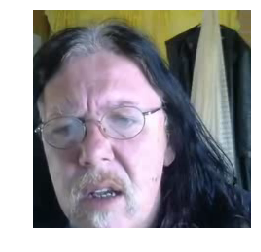

In [70]:
label = analyzer.label_prob(logit[0])
fig, ax = analyzer.show_video(video[0])

In [74]:
train_filtered.index

[{'category': 'frowning',
  'directory': '../data/MIT_data/training/frowning',
  'filename': 'v186_0056.mp4',
  'train': 'train',
  'object_label': 'man',
  'scene_label': nan,
  'object_label_list': ['man']},
 {'category': 'frowning',
  'directory': '../data/MIT_data/training/frowning',
  'filename': 'v186_0083.mp4',
  'train': 'train',
  'object_label': 'man',
  'scene_label': nan,
  'object_label_list': ['man']},
 {'category': 'frowning',
  'directory': '../data/MIT_data/training/frowning',
  'filename': 'v186_0075.mp4',
  'train': 'train',
  'object_label': 'man',
  'scene_label': nan,
  'object_label_list': ['man']},
 {'category': 'reading',
  'directory': '../data/MIT_data/training/reading',
  'filename': 'v184_0088.mp4',
  'train': 'train',
  'object_label': 'man',
  'scene_label': nan,
  'object_label_list': ['man']},
 {'category': 'reading',
  'directory': '../data/MIT_data/training/reading',
  'filename': 'v184_0078.mp4',
  'train': 'train',
  'object_label': 'man',
  'scene_

In [29]:
sorted(label.items(), key=lambda x: x[1], reverse=True)

[('man', 0.23896562),
 ('woman', 0.21111286),
 ('water', 0.10531019),
 ('hand', 0.10450132),
 ('grass', 0.060538419),
 ('crowd', 0.057353832),
 ('boy', 0.055607431),
 ('girl', 0.049810223),
 ('machine', 0.046665758),
 ('dog', 0.043934774),
 ('sky', 0.037572011),
 ('baby', 0.036383372),
 ('car', 0.036266077),
 ('tree', 0.032035124),
 ('smoke', 0.027233474),
 ('road', 0.025782008),
 ('snow', 0.024773801),
 ('keyboard', 0.020774961),
 ('wood', 0.019797934),
 ('boat', 0.018500792),
 ('rock', 0.01789177),
 ('pen', 0.01724508),
 ('sand', 0.015559904),
 ('fire', 0.014679744),
 ('injection', 0.014486101),
 ('foot', 0.013455661),
 ('ground', 0.013424629),
 ('cat', 0.013388011),
 ('leaf', 0.013222829),
 ('phone', 0.01286749),
 ('beach', 0.012724481),
 ('monkey', 0.012708808),
 ('painting', 0.012240116),
 ('paper', 0.011938932),
 ('bird', 0.011823663),
 ('handcuff', 0.011765262),
 ('cloth', 0.011533883),
 ('broom', 0.011532367),
 ('guitar', 0.011286872),
 ('net', 0.011184495),
 ('flower', 0.01111

changed


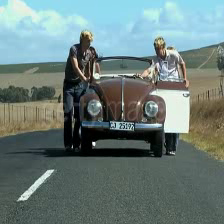

In [19]:
sample = val_dataset[4]
video = sample["video"].unsqueeze(0)
label = sample["label"]
logit = i3d(video)
video_array = video[0].numpy()
video_array = np.transpose(video_array, axes=[1, 2, 3, 0])
image = video_array[10]
Image.fromarray(image.astype('uint8'))

In [30]:
df = train_dataset.index

In [35]:
df.query("object_label.str.match('man')")

,category,directory,filename,train,object_label,scene_label
index,,,,,,
8,frowning,../data/MIT_data/training/frowning,v186_0056.mp4,train,man,NaN
9,frowning,../data/MIT_data/training/frowning,v186_0083.mp4,train,man,NaN
10,frowning,../data/MIT_data/training/frowning,v186_0055.mp4,train,man telephone,NaN
15,frowning,../data/MIT_data/training/frowning,v186_0075.mp4,train,man,NaN
26,reading,../data/MIT_data/training/reading,v184_0088.mp4,train,man,NaN
29,reading,../data/MIT_data/training/reading,v184_0078.mp4,train,man,NaN
40,shouting,../data/MIT_data/training/shouting,v085_0092.mp4,train,man baby,NaN
55,photographing,../data/MIT_data/training/photographing,v138_0056.mp4,train,man phone,NaN
64,juggling,../data/MIT_data/training/juggling,v253_0039.mp4,train,man phone,NaN


In [39]:
dict_ls = df.to_dict(orient="records")

In [41]:
dict_ls[0]

{'category': 'breaking',
 'directory': '../data/MIT_data/training/breaking',
 'filename': 'v018_0048.mp4',
 'train': 'train',
 'object_label': 'hand cigarette',
 'scene_label': nan}

In [ ]:
dict_ls[1,4,5]